In [108]:
# Load Data

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/data-collection/dataset/Full/combined_pm25_73T_dataset.csv")

forecast_df = pd.read_csv("/content/drive/MyDrive/data-collection/dataset/Full/combined_pm25_73T_forecast_dataset.csv")

In [110]:
# Inspect Data

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

df.set_index("date", inplace = True)

forecast_df["date"] = pd.to_datetime(forecast_df["date"])
forecast_df = forecast_df.sort_values("date")

forecast_df.set_index("date", inplace = True)

In [111]:
# Interpolation

df["pm25"] = df["pm25"].interpolate(method = "linear")
forecast_df["pm25"] = forecast_df["pm25"].interpolate(method = "linear")

In [112]:
df_filtered = df[(df.index.year >= 2019) & (df.index.year <= 2023)]
forecast_df_filtered = forecast_df[forecast_df.index.year == 2024]

df = pd.concat([df_filtered, forecast_df_filtered])

In [113]:
# Prophet Modeling

from prophet import Prophet

df_prophet = df_filtered.copy()
df_prophet["ds"] = df_prophet.index
df_prophet = df_prophet[["ds", "pm25"]].rename(columns = {"pm25": "y"})

model_prophet = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = False)
model_prophet.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgeu7pzt5/h8p_x6y4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgeu7pzt5/78ysciff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51972', 'data', 'file=/tmp/tmpgeu7pzt5/h8p_x6y4.json', 'init=/tmp/tmpgeu7pzt5/78ysciff.json', 'output', 'file=/tmp/tmpgeu7pzt5/prophet_modelig_ki2oy/prophet_model-20250503034249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:42:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:42:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [114]:
prophet_forecast = model_prophet.predict(pd.DataFrame({"ds": df.index}))

prophet_forecast["residual"] = df["pm25"].values - prophet_forecast["yhat"].values

prophet_forecast.set_index("ds", inplace = True)

In [115]:
# Feature Engineering

import numpy as np

def create_features(df):
    df = df.copy()

    ### 1. Calendar features ###
    df["month"] = df.index.month
    df["month_sin"] = np.sin(2 * np.pi * df["month"]/12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"]/12)
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["weekofyear"] = df.index.isocalendar().week.astype(int)

    ### 2. Weather features ###
    df["wind_x"] = np.cos(np.radians(df["winddirection_10m_dominant (°)"]))
    df["wind_y"] = np.sin(np.radians(df["winddirection_10m_dominant (°)"]))

    # Lag Rolling for important weather
    weather_cols = [
        "relative_humidity_2m_mean (%)",
        "temperature_2m_mean (°C)_center",
        "precipitation_sum (mm)_center",
        "surface_pressure_mean (hPa)",
        "wind_speed_10m_mean (km/h)",
        "cloud_cover_mean (%)",
    ]
    for col in weather_cols:
        for lag in [1, 3, 7, 14]:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
        for window in [7, 14]:
            df[f"{col}_rolling_mean_{window}"] = df[col].rolling(window=window).mean()
            df[f"{col}_rolling_std_{window}"] = df[col].rolling(window=window).std()

    ### 3. Aggregated regional weather ###
    df["temperature_mean_all_regions"] = df[[
        "temperature_2m_mean (°C)_north",
        "temperature_2m_mean (°C)_south",
        "temperature_2m_mean (°C)_east",
        "temperature_2m_mean (°C)_west",
    ]].mean(axis=1)

    df["precipitation_sum_all_regions"] = df[[
        "precipitation_sum (mm)_north",
        "precipitation_sum (mm)_south",
        "precipitation_sum (mm)_east",
        "precipitation_sum (mm)_west",
    ]].sum(axis=1)

    ### 4. PM2.5 past behavior ###
    for lag in [1, 2, 3, 7, 14, 21, 30]:
        df[f"pm25_lag_{lag}"] = df["pm25"].shift(lag)
    for window in [7, 14, 30]:
        df[f"pm25_rolling_mean_{window}"] = df["pm25"].rolling(window=window).mean()
        df[f"pm25_rolling_std_{window}"] = df["pm25"].rolling(window=window).std()
        df[f"pm25_rolling_max_{window}"] = df["pm25"].rolling(window=window).max()
        df[f"pm25_rolling_min_{window}"] = df["pm25"].rolling(window=window).min()

    # PM25 diff and expanding
    df["pm25_diff_1"] = df["pm25"].diff(1)
    df["pm25_expanding_mean"] = df["pm25"].expanding().mean()

    # Moving average of lagged PM2.5
    df["pm25_lag_1_3_mean"] = (df["pm25"].shift(1) + df["pm25"].shift(2) + df["pm25"].shift(3)) / 3

    ### Handle missing value filling ###
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:
            df[col] = df[col].fillna(df[col].mean())

    return df

In [116]:
df_features_ = create_features(df)

df_features = df_features_.join(prophet_forecast, how = "inner")

In [117]:
# Feature Selection

!pip -q install -U xgboost

In [118]:
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def select_features(X, y, method = "hybrid", n_features = None, threshold = None):
    feature_names = X.columns.tolist()
    importances = {}

    # 1. Correlation Analysis (Linear Relationships Measurement Method)
    if method in ["correlation", "hybrid"]:
        print("Process correlation method ...")
        corr = np.abs(pd.DataFrame({"target": y}).join(X).corr(method = "spearman")["target"])
        corr = corr.drop("target")
        importances["correlation"] = corr

    # 2. Mutual Information (Non-Linear Relationships Measurement Method)
    if method in ["mutual_info", "hybrid"]:
        print("Process mutual_info method ...")
        mi = mutual_info_regression(X, y)
        mi_scores = pd.Series(mi, index=feature_names)
        importances["mutual_info"] = mi_scores

    # 3. Random Forest Feature Importance
    if method in ["rf", "hybrid"]:
        print("Process rf method ...")
        rf = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 42, n_jobs = -1)
        rf.fit(X, y)
        rf_importances = pd.Series(rf.feature_importances_, index=feature_names)
        importances["random_forest"] = rf_importances

        print("Sub process Permutation Importance")
        perm_importance = permutation_importance(rf, X, y, n_repeats = 10, random_state = 42, n_jobs = -1)
        perm_importances = pd.Series(perm_importance.importances_mean, index=feature_names)
        importances["permutation"] = perm_importances

    # 4. XGBoost Feature Importance)
    if method in ["xgboost", "hybrid"]:
        print("Process xgboost method ...")
        xgb = XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 5, random_state = 42, enable_categorical = True)
        xgb.fit(X, y)
        xgb_importances = pd.Series(xgb.feature_importances_, index=feature_names)
        importances["xgboost"] = xgb_importances

    # Combine feature importance scores
    if method == "hybrid":
        print("Process hybrid method ...")
        ranks = {name: importance.rank(ascending = False) for name, importance in importances.items()}

        # Compute Avg Rank
        avg_rank = pd.DataFrame(ranks).mean(axis = 1)
        final_importance = 1 / avg_rank  # Convert to importance where high rank = important
        importances["hybrid"] = final_importance

        # Features Selection
        selected_importance = final_importance
    else:
        selected_importance = importances[method]

    # Select features based on n_features or threshold
    if n_features is not None:
        selected_features = selected_importance.nlargest(n_features).index.tolist()
    elif threshold is not None:
        max_importance = selected_importance.max()
        selected_features = selected_importance[selected_importance >= max_importance * threshold].index.tolist()
    else:
        selected_features = selected_importance.nlargest(min(15, len(feature_names))).index.tolist()

    return selected_features, importances

In [119]:
selected_features, importances = select_features(
    df_features.drop(["pm25", "residual"], axis = 1), df_features["residual"],
    method = "hybrid",
    n_features = 30
)

Process correlation method ...
Process mutual_info method ...
Process rf method ...
Sub process Permutation Importance
Process xgboost method ...
Process hybrid method ...


In [120]:
# Data Praparation

data = df_features[selected_features + ["residual", "pm25"]]

train_end_date = pd.to_datetime("2023-12-31")
test_start_date = pd.to_datetime("2024-1-1")

# Train set
X_train = data.loc[:train_end_date].drop(columns = ["residual", "pm25"])
y_train = data.loc[:train_end_date]["residual"]

# Test set
X_test = data.loc[test_start_date:].drop(columns = ["residual", "pm25"])
y_test = data.loc[test_start_date:]["residual"]

In [121]:
# Residual Modeling

xgb_model = XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 5, random_state = 42)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [122]:
# Evaluation

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

y_true = data.loc[test_start_date:]["pm25"]
prophet_pred = prophet_forecast.loc[y_test.index, "yhat"]
hybrid_pred = prophet_forecast.loc[X_test.index, "yhat"] + xgb_model.predict(X_test)

Overall_results = []

mae = mean_absolute_error(y_true, prophet_pred)
rmse = np.sqrt(mean_squared_error(y_true, prophet_pred))
mape = mean_absolute_percentage_error(y_true, prophet_pred)

Overall_results.append({
    "Model": "Prophet",
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape
})

mae = mean_absolute_error(y_true, hybrid_pred)
rmse = np.sqrt(mean_squared_error(y_true, hybrid_pred))
mape = mean_absolute_percentage_error(y_true, hybrid_pred)

Overall_results.append({
    "Model": "Hybrid_XGBoost",
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape
})

In [123]:
Overall_results_df = pd.DataFrame(Overall_results)
Overall_results_df

,Model,MAE,RMSE,MAPE
0,Prophet,12.762206,26.784277,0.366036
1,Hybrid_XGBoost,4.178419,7.850866,0.125193


In [124]:
# Fine-Tuned Residual Model Using Cross Validation Technique

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model = XGBRegressor(random_state = 42)

tscv = TimeSeriesSplit(n_splits = 5)

param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = tscv,
    scoring = "neg_mean_squared_error",
    n_jobs = -1,
    verbose = 1
)

In [125]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [126]:
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


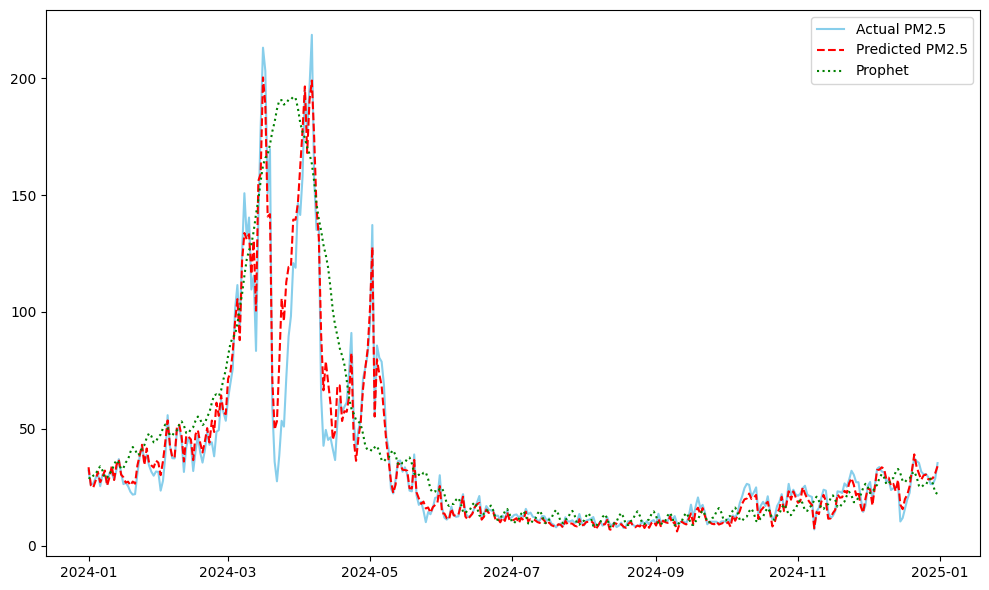

In [127]:
import matplotlib.pyplot as plt

hybrid_pred = prophet_forecast.loc[X_test.index, "yhat"] + best_model.predict(X_test)

plt.figure(figsize = (10, 6))

plt.plot(X_test.index, y_true, label = "Actual PM2.5", color = "skyblue")
plt.plot(X_test.index, hybrid_pred, label = "Predicted PM2.5", color = "red", linestyle = "--")
plt.plot(X_test.index, prophet_pred, label = "Prophet", color = "green", linestyle = ":")

plt.legend()
plt.tight_layout()
plt.show()

In [128]:
# Full Evaluation (Base on Proposal)
## Overall Performance

y_true = data.loc[test_start_date:]["pm25"]
prophet_pred = prophet_forecast.loc[y_test.index, "yhat"]
hybrid_pred = prophet_forecast.loc[X_test.index, "yhat"] + best_model.predict(X_test)

Overall_results = []

mae = mean_absolute_error(y_true, prophet_pred)
rmse = np.sqrt(mean_squared_error(y_true, prophet_pred))
mape = mean_absolute_percentage_error(y_true, prophet_pred)

Overall_results.append({
    "Model": "Prophet",
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape
})

mae = mean_absolute_error(y_true, hybrid_pred)
rmse = np.sqrt(mean_squared_error(y_true, hybrid_pred))
mape = mean_absolute_percentage_error(y_true, hybrid_pred)

Overall_results.append({
    "Model": "Hybrid_XGBoost",
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape
})

Overall_results_df = pd.DataFrame(Overall_results)
Overall_results_df

,Model,MAE,RMSE,MAPE
0,Prophet,12.762206,26.784277,0.366036
1,Hybrid_XGBoost,3.996706,7.784802,0.115013


In [129]:
## Critical Periods (March)

march_2024 = data[(data.index.month == 3) & (data.index.year == 2024)]
march_2024

y_true = march_2024["pm25"]
y_pred_prophet = prophet_forecast.loc[march_2024.index, "yhat"]
y_pred_hybrid =  y_pred_prophet + best_model.predict(march_2024.drop(columns = ["pm25", "residual"]))

In [130]:
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred_prophet))
mape_prophet = mean_absolute_percentage_error(y_true, y_pred_prophet) * 100

mae_hybrid = mean_absolute_error(y_true, y_pred_hybrid)
rmse_hybrid = np.sqrt(mean_squared_error(y_true, y_pred_hybrid))
mape_hybrid = mean_absolute_percentage_error(y_true, y_pred_hybrid) * 100

In [131]:
print("📈 Prophet Model (March 2024)")
print(f"MAE  = {mae_prophet:.4f}")
print(f"RMSE = {rmse_prophet:.4f}")
print(f"MAPE = {mape_prophet:.2f}%\n")

print("🔀 Hybrid Model (Prophet + Residual, March 2024)")
print(f"MAE  = {mae_hybrid:.4f}")
print(f"RMSE = {rmse_hybrid:.4f}")
print(f"MAPE = {mape_hybrid:.2f}%")

📈 Prophet Model (March 2024)
MAE  = 56.2305
RMSE = 75.8128
MAPE = 95.61%

🔀 Hybrid Model (Prophet + Residual, March 2024)
MAE  = 16.9309
RMSE = 21.4257
MAPE = 24.20%


In [132]:
# Multi-Horizon Evaluation

def evaluate_hybrid_model_horizons(horizons, data, prophet_forecast, best_model):
    results = []

    test_mask = data.index.year == 2024
    df_test = data[test_mask]
    test_dates = df_test.index

    for horizon in horizons:
        preds = []
        actuals = []

        max_index = len(test_dates) - horizon - 1
        if max_index < 0:
            results.append({
                "Horizon": f"{horizon} days",
                "RMSE": None,
                "MAE": None,
                "MAPE": None
            })
            continue

        for i in range(max_index + 1):
            current_time = test_dates[i]
            future_time = test_dates[i + horizon]

            try:
                # Prophet prediction h steps ahead
                prophet_pred = prophet_forecast.loc[future_time, "yhat"]

                # Residual model prediction at current time
                X_input = data.loc[[current_time]].drop(columns=["pm25", "residual"])
                residual_pred = best_model.predict(X_input)[0]

                hybrid_pred = prophet_pred + residual_pred
                actual_value = data.loc[future_time, "pm25"]

                preds.append(hybrid_pred)
                actuals.append(actual_value)
            except KeyError:
                continue  # skip if any time index missing
            except IndexError:
                continue

        if actuals:
            results.append({
                'Horizon': f'{horizon} days',
                'RMSE': np.sqrt(mean_squared_error(actuals, preds)),
                'MAE': mean_absolute_error(actuals, preds),
                'MAPE': mean_absolute_percentage_error(actuals, preds) * 100
            })
        else:
            results.append({
                'Horizon': f'{horizon} days',
                'RMSE': None,
                'MAE': None,
                'MAPE': None
            })

    return pd.DataFrame(results)


In [133]:
horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
results = evaluate_hybrid_model_horizons(horizons, data, prophet_forecast, best_model)
print(results)

    Horizon       RMSE        MAE       MAPE
0    1 days  12.710311   6.961002  21.254440
1    2 days  16.389135   9.186415  29.109393
2    3 days  20.119951  10.715203  34.310285
3    4 days  23.895456  12.174215  38.175333
4    5 days  26.330719  12.883033  39.362680
5    6 days  28.656270  13.867579  38.699601
6    7 days  29.891757  14.453884  39.065742
7    8 days  31.398257  15.765558  42.714425
8    9 days  32.336070  16.722068  46.382344
9   10 days  33.312441  17.556907  49.493445
10  11 days  33.893523  17.736097  49.843959
11  12 days  34.280590  17.632385  48.381445
12  13 days  34.600915  17.189043  45.004143
13  14 days  34.399913  16.853789  43.061527
14  15 days  34.414438  16.721964  42.691307
15  16 days  34.261848  16.594219  45.345484


In [134]:
# Threshold-Based Metrics (Critical Level Detection)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, fbeta_score

threshold = 37.5  # PM2.5 critical threshold in µg/m³

# Define test set (year 2024)
test_mask = data.index.year == 2024
df_test = data[test_mask]
test_index = df_test.index

# Step 1: True values
y_test = df_test["pm25"]

# Step 2: Hybrid predictions
y_pred_prophet = prophet_forecast.loc[test_index, "yhat"]
X_boost = data.loc[test_index].drop(columns=["pm25", "residual"])
y_pred_hybrid = y_pred_prophet + best_model.predict(X_boost)

# Step 3: Binary classification labels
y_test_class = (y_test > threshold).astype(int)
hybrid_test_class = (y_pred_hybrid > threshold).astype(int)

# Step 4: Classification metrics
test_cm = confusion_matrix(y_test_class, hybrid_test_class)
test_f2 = fbeta_score(y_test_class, hybrid_test_class, beta=2)
test_precision = precision_score(y_test_class, hybrid_test_class)
test_recall = recall_score(y_test_class, hybrid_test_class)

# --- Output ---
print("\nCritical Level Detection (PM2.5 > 37.5 μg/m³) Performance (Test Set):")
print(f"F2 Score: {test_f2:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print("\nConfusion Matrix:")
print(test_cm)


Critical Level Detection (PM2.5 > 37.5 μg/m³) Performance (Test Set):
F2 Score: 0.9595
Precision: 0.9278
Recall: 0.9677

Confusion Matrix:
[[266   7]
 [  3  90]]


In [135]:
# Make Reward Model
Actual_data = df[(df.index.year >= 2019) & (df.index.year <= 2022)]
Forecast_data = forecast_df

combined_df = pd.concat([Actual_data, Forecast_data])

In [136]:
df_prophet = combined_df.copy()
df_prophet["ds"] = df_prophet.index
df_prophet = df_prophet[["ds", "pm25"]].rename(columns={"pm25": "y"})

model_prophet = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = False)
model_prophet.fit(df_prophet)

prophet_forecast = model_prophet.predict(pd.DataFrame({"ds": combined_df.index}))

prophet_forecast["residual"] = combined_df["pm25"].values - prophet_forecast["yhat"].values

prophet_forecast.set_index("ds", inplace = True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgeu7pzt5/la__8kv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgeu7pzt5/70d3rm5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26020', 'data', 'file=/tmp/tmpgeu7pzt5/la__8kv5.json', 'init=/tmp/tmpgeu7pzt5/70d3rm5x.json', 'output', 'file=/tmp/tmpgeu7pzt5/prophet_model97m5atlf/prophet_model-20250503034739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:47:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [137]:
DATA_features = create_features(combined_df)

DATA_features = DATA_features.join(prophet_forecast, how = "inner")

DATA = DATA_features[selected_features + ["residual", "pm25"]]

In [138]:
# Retrain with Full Data
X = DATA.drop(columns = ["pm25", "residual"])
y = DATA["residual"]

final_model = XGBRegressor(**grid_search.best_params_, random_state = 42)
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [139]:
from prophet.serialize import model_to_json
import pickle

station_id = "73T" # Station ID ⚠️ อย่าลืมเปลี่ยนด้วยนะ!

with open(f"prophet_model_{station_id}.json", "w") as f:
    f.write(model_to_json(model_prophet))

final_model.save_model(f"residual_model_{station_id}.cbm")

with open(f"selected_features_{station_id}.pkl", "wb") as f:
    pickle.dump(selected_features, f)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [03:47:41] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
